In [1]:
import pandas as pd
import numpy as np
from collections import namedtuple
import tensorflow as tf
from string import punctuation
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.metrics import roc_curve, auc, classification_report
from tqdm import tqdm

C:\Users\Pink\AppData\Local\Continuum\anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
df=pd.read_csv('Amazon Reviews.csv')
df=df.iloc[0:1000,:]
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [3]:
## print the Number of Reviews
print("Number of reviews:",len(df))

Number of reviews: 1000


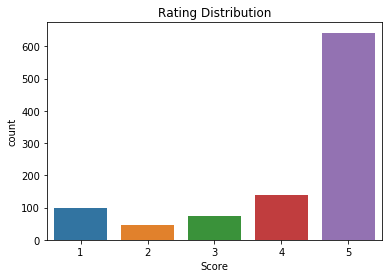

In [4]:
## Rating Distribution
ax = plt.axes()
sns.countplot(df.Score,ax=ax)
ax.set_title('Rating Distribution')
plt.show()

In [5]:
## Working on positive and negeative reviews
df_positive=df.loc[df.Score>3,'Text']
df_negeative=df.loc[df.Score<=3,'Text']
print('Number of positive reviews-->',len(df_positive),'\nNumber of negeative reviews-->',len(df_negeative))

Number of positive reviews--> 780 
Number of negeative reviews--> 220


In [6]:
## Ratio of Reviews 
print('Ratio of positive reviews-->',len(df_positive)/len(df),'\nRatio of negeative reviews-->',len(df_negeative)/len(df))

Ratio of positive reviews--> 0.78 
Ratio of negeative reviews--> 0.22


In [7]:
df['Review_label']= np.where(df['Score']>3, '1', '0')
df['Review_label'].head()

0    1
1    0
2    1
3    0
4    1
Name: Review_label, dtype: object

In [8]:
postive_review_words=0
negative_review_words=0
for i in range(len(df)):
    if df['Review_label'][i]=='1':
        postive_review_words=postive_review_words+len(df['Text'][i])
    else:
        negative_review_words=negative_review_words+len(df['Text'][i])
print('Total Number of Words in Positive Reviews-->',postive_review_words,'\nTotal Number of Words in Positive Reviews-->', negative_review_words)

Total Number of Words in Positive Reviews--> 302995 
Total Number of Words in Positive Reviews--> 93856


In [9]:
## Length of First Sentence
len(df['Text'][0])

263

# Data Cleansing

### Lower Case/Punctuation

In [10]:
import os
import re

In [11]:
## Data Cleansing
## Removing Punctuation and Lower-Case all the strings
def remove_punc(text):
    text=re.sub(r"[^a-zA-Z0-9]+",' ',text)
    text = re.sub(r'[0-9]+', '', text)
    text=re.sub(r'<[^>]+>','',text)
    
    return text.lower()
df['Text'] = [remove_punc(df['Text'][x]) for x in range(len(df))]
### Finding the Length of first paragraph after removing Punctuation
print(('Finding the Length of first paragraph after removing Punctuation-->'),len(df['Text'][0]))

Finding the Length of first paragraph after removing Punctuation--> 260


### Removing Emoticons

In [12]:
### Removing Emoticons
def remove_punc(text):
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)
df['Text']  = [remove_punc(df['Text'][x]) for x in range(len(df))]

print(('Finding the Length of first paragraph after removing Emoticons-->'),len(df['Text'][0]))

Finding the Length of first paragraph after removing Emoticons--> 260


### Removing of Stop Words

In [13]:
from nltk.corpus import stopwords
import nltk
stop_words = set(stopwords.words('english'))

In [14]:
## Converting it into lists
raw_docs_train = df['Text'] .tolist()

In [15]:
## Removal of Stop Words
processed_docs_train_SW = []
for w in tqdm(range(len(raw_docs_train))):
    tokenizer=nltk.word_tokenize(raw_docs_train[w])
    filtered = [word for word in tokenizer if word not in stop_words]     
    processed_docs_train_SW.append(filtered)

print(('Finding the Length of first paragraph after removing Stop-Words-->'),(len(processed_docs_train_SW[0])))
print('Length of dataset',len(processed_docs_train_SW))

100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1265.25it/s]


Finding the Length of first paragraph after removing Stop-Words--> 23
Length of dataset 1000


In [16]:
print("Before: ",df['Text'][3])
print("-------------------------------------------------------------------------------------------------------")
print("After: "," ".join(processed_docs_train_SW[3]))

Before:  if you are looking for the secret ingredient in robitussin i believe i have found it i got this in addition to the root beer extract i ordered which was good and made some cherry soda the flavor is very medicinal 
-------------------------------------------------------------------------------------------------------
After:  looking secret ingredient robitussin believe found got addition root beer extract ordered good made cherry soda flavor medicinal


### False Word

In [17]:
## Find the Length of every words From the corpus
len_word={}
for w in tqdm(range(len(processed_docs_train_SW))):
    for wds in processed_docs_train_SW[w]:
           len_word[wds]=len(wds)

100%|███████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 49375.54it/s]


In [18]:
## I am taking v is greater than 25,because Maximum length of english word is 25
## Don't remove the word which consists 'no'
false_word=list(((k) for k, v in len_word.items() if (v == 1 or (v == 2 and k!='no')or v >= 25 or k=='lol')))
print("Length of false_word is-->",len(false_word))

Length of false_word is--> 93


In [19]:
## Removing Words from False List
processed_docs_train_FW=[]
for w in tqdm(range(len(processed_docs_train_SW))):
    filtered1 = [word for word in processed_docs_train_SW[w] if word not in false_word] 
    processed_docs_train_FW.append(filtered1)

print("Length of Dataset after false_word is-->",len(processed_docs_train_FW))

100%|███████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 13538.83it/s]


Length of Dataset after false_word is--> 1000


### Rare Words

In [20]:
words={}
for wds in tqdm(range(len(processed_docs_train_FW))):
    for w in processed_docs_train_FW[wds]:
        if w in words:
            words[w]=words[w]+1
        else:
            words[w]=1  

100%|███████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 70958.80it/s]


In [21]:
#b = dict( (key, value) for (key, value) in a.items() if key == "hello" )
sorted_words_dict=dict(sorted(words.items(), key=lambda kv: kv[1]))

In [22]:
## getting a Rare Words Having count 1 and 2.
rare_words = list(((k) for k, v in sorted_words_dict.items() if (v == 1 or v == 2)))
rare_words=sorted(rare_words)
print("Length of rare_words is-->",len(rare_words))

Length of rare_words is--> 3536


In [23]:
### Removing Words which repeats Many Times
processed_docs_train_RW=[]
for w in tqdm(range(len(processed_docs_train_FW))):
    filtered2 = [word for word in processed_docs_train_FW[w] if word not in rare_words] 
    processed_docs_train_RW.append(filtered2)

print("Length of Dataset after Rare Words is-->",len(processed_docs_train_RW))

100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 242.70it/s]


Length of Dataset after Rare Words is--> 1000


### Frequent Words

In [24]:
print('*************** NEED To UPDATE FREQUENT WORDS ***************')

*************** NEED To UPDATE FREQUENT WORDS ***************


In [25]:
#print(sorted_words_dict)
freq_words = list(((k) for k, v in sorted_words_dict.items() if (k == 'please' or k=='would')))
print("Length of freq_words is-->",len(freq_words))

Length of freq_words is--> 2


In [26]:
processed_docs_train_af_FW = []
for w in tqdm(range(len(processed_docs_train_RW))):
    filtered2 = [word for word in processed_docs_train_RW[w] if word not in freq_words] 
    processed_docs_train_af_FW.append(filtered2)

print("Length of Dataset after Frequent-Words is-->",len(processed_docs_train_af_FW))

100%|██████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 129770.24it/s]


Length of Dataset after Frequent-Words is--> 1000


### lemmatization

In [27]:
from nltk.stem import WordNetLemmatizer
#import the nltk package
import nltk
#call the nltk downloader
nltk.download('wordnet')
wordnet_lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Pink\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [28]:
processed_docs_train_Lemz=[]
for w in tqdm(range(len(processed_docs_train_af_FW))):
    lemmatization=[wordnet_lemmatizer.lemmatize(word) for word in processed_docs_train_af_FW[w] ]
    #processed_docs_train_Lemz.append(" ".join(lemmatization))
    processed_docs_train_Lemz.append(lemmatization)

print("Length of Dataset after lemmatization is-->",len(processed_docs_train_Lemz))

100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 273.42it/s]


Length of Dataset after lemmatization is--> 1000


In [29]:
print("Before: ",df['Text'][5])
print("-------------------------------------------------------------------------------------------------------")
print("After: "," ".join(processed_docs_train_SW[5]))

Before:  i got a wild hair for taffy and ordered this five pound bag the taffy was all very enjoyable with many flavors watermelon root beer melon peppermint grape etc my only complaint is there was a bit too much red black licorice flavored pieces just not my particular favorites between me my kids and my husband this lasted only two weeks i would recommend this brand of taffy it was a delightful treat 
-------------------------------------------------------------------------------------------------------
After:  got wild hair taffy ordered five pound bag taffy enjoyable many flavors watermelon root beer melon peppermint grape etc complaint bit much red black licorice flavored pieces particular favorites kids husband lasted two weeks would recommend brand taffy delightful treat


# Word Embedding (Count Vectorizer)

In [30]:
## Dictionay of unique Words
words={}
for wds in tqdm(range(len(processed_docs_train_Lemz))):
    for w in processed_docs_train_Lemz[wds]:
        if w in words:
            words[w]=words[w]+1
        else:
            words[w]=1  

100%|███████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 34316.81it/s]


In [31]:
## Converting List into Sentences
corpus=[]
for i in tqdm(range(len(processed_docs_train_Lemz))):
    corpus.append(" ".join(processed_docs_train_Lemz[i]))
print('length oc corpus',len(corpus))   

100%|██████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 235291.37it/s]


length oc corpus 1000


In [32]:
df_Refine_text = pd.DataFrame(corpus,columns=['Refine_text'])

In [33]:
## Concatenateing the two Data-Frames
DfData=pd.concat([df, df_Refine_text], axis=1)
DfData.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Review_label,Refine_text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,i have bought several of the vitality canned d...,1,bought several canned dog food product found g...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,product arrived labeled as jumbo salted peanut...,0,product arrived salted peanut peanut actually ...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",this is a confection that has been around a fe...,1,around light citrus nut case cut tiny square c...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,if you are looking for the secret ingredient i...,0,looking secret ingredient believe found got ad...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,great taffy at a great price there was a wide ...,1,great taffy great price yummy taffy delivery q...


In [34]:
## Target Data
df_y=DfData["Review_label"]
## Independent Variable
df_x=DfData["Refine_text"]

In [35]:
from sklearn.feature_extraction.text import CountVectorizer
print('************************ Count Vectorizer Starts From Here ************************')

************************ Count Vectorizer Starts From Here ************************


In [36]:
#ngram_range=(1,2),max_df=1.0,min_df=1,
cv=CountVectorizer(stop_words='english',max_features=1200)
df_xcv=cv.fit_transform(df_x)

In [37]:
print('How Documnet one is look like after selecting max_features')
print('---------------------------------------------------------------')
print(cv.inverse_transform(df_xcv[1,:]))

How Documnet one is look like after selecting max_features
---------------------------------------------------------------
[array(['vendor', 'sure', 'unsalted', 'sized', 'small', 'actually',
       'peanut', 'salted', 'arrived', 'product'], dtype='<U14')]


In [38]:
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense,Embedding
from keras.layers import LSTM
print("------------------------------- Model Training Starts From Here -----------------------------------")

Using TensorFlow backend.


------------------------------- Model Training Starts From Here -----------------------------------


In [39]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df_xcv, df_y, test_size=0.33, random_state=123)
### Convering sparse-matrix into an Array
X_train=X_train.toarray()
X_test=X_test.toarray()
print('Length of Train Data-set',len(X_train))
print('Length of Test Data-set',len(X_test))

Length of Train Data-set 670
Length of Test Data-set 330


In [40]:
X_traincv = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))
X_traincv=np.array(X_traincv,dtype=np.float32)
print(X_traincv.shape)

(670, 1200, 1)


In [41]:
X_testcv = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
X_testcv=np.array(X_testcv,dtype=np.float32)
print(X_testcv.shape)

(330, 1200, 1)


In [42]:
y_train=np.array(y_train)
#y_traincv=np.reshape(y_train.shape,(y_train.shape[0]))

In [43]:
#embed_dim=128
lstm_out=1
batch_size=32

model=Sequential()
#model.add(Embedding(2500,embed_dim,input_length=X_traincv.shape[1],dropout=.2))
model.add(LSTM(1,batch_input_shape=(None,1200,1),return_sequences=False))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss = 'binary_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 1)                 12        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 2         
Total params: 14
Trainable params: 14
Non-trainable params: 0
_________________________________________________________________
None


In [44]:
#Here we train the Network.
model.fit(X_traincv,y_train, batch_size=batch_size,epochs =50, verbose = 1,validation_data=(X_testcv,y_test))

Train on 670 samples, validate on 330 samples
Epoch 1/50
670/670 [==============================] - ETA: 39s - loss: 0.6930 - acc: 0.37 - ETA: 25s - loss: 0.6929 - acc: 0.57 - ETA: 20s - loss: 0.6929 - acc: 0.61 - ETA: 17s - loss: 0.6927 - acc: 0.66 - ETA: 15s - loss: 0.6923 - acc: 0.68 - ETA: 13s - loss: 0.6921 - acc: 0.70 - ETA: 12s - loss: 0.6921 - acc: 0.70 - ETA: 11s - loss: 0.6918 - acc: 0.71 - ETA: 10s - loss: 0.6916 - acc: 0.72 - ETA: 9s - loss: 0.6913 - acc: 0.7375 - ETA: 8s - loss: 0.6912 - acc: 0.735 - ETA: 7s - loss: 0.6911 - acc: 0.724 - ETA: 6s - loss: 0.6908 - acc: 0.735 - ETA: 5s - loss: 0.6908 - acc: 0.734 - ETA: 4s - loss: 0.6904 - acc: 0.747 - ETA: 3s - loss: 0.6902 - acc: 0.748 - ETA: 3s - loss: 0.6900 - acc: 0.748 - ETA: 2s - loss: 0.6898 - acc: 0.750 - ETA: 1s - loss: 0.6896 - acc: 0.751 - ETA: 0s - loss: 0.6895 - acc: 0.751 - 17s 26ms/step - loss: 0.6892 - acc: 0.7537 - val_loss: 0.6848 - val_acc: 0.8030
Epoch 2/50
670/670 [==============================] - ETA: 

670/670 [==============================] - ETA: 14s - loss: 0.5447 - acc: 0.84 - ETA: 13s - loss: 0.5696 - acc: 0.79 - ETA: 13s - loss: 0.5608 - acc: 0.81 - ETA: 11s - loss: 0.5648 - acc: 0.80 - ETA: 11s - loss: 0.5739 - acc: 0.78 - ETA: 10s - loss: 0.5685 - acc: 0.79 - ETA: 9s - loss: 0.5744 - acc: 0.7857 - ETA: 9s - loss: 0.5744 - acc: 0.785 - ETA: 8s - loss: 0.5841 - acc: 0.767 - ETA: 7s - loss: 0.5761 - acc: 0.781 - ETA: 7s - loss: 0.5742 - acc: 0.784 - ETA: 6s - loss: 0.5786 - acc: 0.776 - ETA: 5s - loss: 0.5836 - acc: 0.766 - ETA: 4s - loss: 0.5802 - acc: 0.772 - ETA: 4s - loss: 0.5797 - acc: 0.772 - ETA: 3s - loss: 0.5826 - acc: 0.767 - ETA: 2s - loss: 0.5819 - acc: 0.768 - ETA: 2s - loss: 0.5813 - acc: 0.769 - ETA: 1s - loss: 0.5788 - acc: 0.773 - ETA: 0s - loss: 0.5793 - acc: 0.771 - 16s 24ms/step - loss: 0.5810 - acc: 0.7687 - val_loss: 0.5564 - val_acc: 0.8030
Epoch 11/50
670/670 [==============================] - ETA: 14s - loss: 0.5508 - acc: 0.81 - ETA: 13s - loss: 0.5599

670/670 [==============================] - ETA: 9s - loss: 0.6487 - acc: 0.656 - ETA: 9s - loss: 0.5540 - acc: 0.765 - ETA: 8s - loss: 0.5585 - acc: 0.760 - ETA: 8s - loss: 0.5540 - acc: 0.765 - ETA: 7s - loss: 0.5676 - acc: 0.750 - ETA: 7s - loss: 0.5675 - acc: 0.750 - ETA: 6s - loss: 0.5636 - acc: 0.754 - ETA: 6s - loss: 0.5607 - acc: 0.757 - ETA: 5s - loss: 0.5523 - acc: 0.767 - ETA: 5s - loss: 0.5428 - acc: 0.778 - ETA: 4s - loss: 0.5450 - acc: 0.775 - ETA: 4s - loss: 0.5423 - acc: 0.778 - ETA: 3s - loss: 0.5463 - acc: 0.774 - ETA: 3s - loss: 0.5517 - acc: 0.767 - ETA: 2s - loss: 0.5472 - acc: 0.772 - ETA: 2s - loss: 0.5433 - acc: 0.777 - ETA: 1s - loss: 0.5446 - acc: 0.775 - ETA: 1s - loss: 0.5474 - acc: 0.772 - ETA: 0s - loss: 0.5470 - acc: 0.773 - ETA: 0s - loss: 0.5479 - acc: 0.771 - 11s 17ms/step - loss: 0.5508 - acc: 0.7687 - val_loss: 0.5192 - val_acc: 0.8030
Epoch 20/50
670/670 [==============================] - ETA: 10s - loss: 0.6779 - acc: 0.62 - ETA: 9s - loss: 0.5943 -

670/670 [==============================] - ETA: 13s - loss: 0.4657 - acc: 0.84 - ETA: 12s - loss: 0.5304 - acc: 0.78 - ETA: 12s - loss: 0.5411 - acc: 0.77 - ETA: 11s - loss: 0.5384 - acc: 0.77 - ETA: 10s - loss: 0.5498 - acc: 0.76 - ETA: 10s - loss: 0.5573 - acc: 0.75 - ETA: 9s - loss: 0.5442 - acc: 0.7679 - ETA: 8s - loss: 0.5546 - acc: 0.757 - ETA: 8s - loss: 0.5555 - acc: 0.756 - ETA: 7s - loss: 0.5725 - acc: 0.740 - ETA: 6s - loss: 0.5509 - acc: 0.761 - ETA: 6s - loss: 0.5491 - acc: 0.763 - ETA: 5s - loss: 0.5452 - acc: 0.766 - ETA: 4s - loss: 0.5488 - acc: 0.763 - ETA: 4s - loss: 0.5497 - acc: 0.762 - ETA: 3s - loss: 0.5464 - acc: 0.765 - ETA: 2s - loss: 0.5435 - acc: 0.768 - ETA: 2s - loss: 0.5428 - acc: 0.769 - ETA: 1s - loss: 0.5438 - acc: 0.768 - ETA: 0s - loss: 0.5415 - acc: 0.770 - 16s 24ms/step - loss: 0.5432 - acc: 0.7687 - val_loss: 0.5069 - val_acc: 0.8030
Epoch 29/50
670/670 [==============================] - ETA: 14s - loss: 0.4970 - acc: 0.81 - ETA: 13s - loss: 0.5134

670/670 [==============================] - ETA: 14s - loss: 0.4566 - acc: 0.84 - ETA: 13s - loss: 0.5448 - acc: 0.76 - ETA: 12s - loss: 0.5742 - acc: 0.73 - ETA: 12s - loss: 0.5448 - acc: 0.76 - ETA: 11s - loss: 0.5554 - acc: 0.75 - ETA: 10s - loss: 0.5389 - acc: 0.77 - ETA: 10s - loss: 0.5221 - acc: 0.78 - ETA: 9s - loss: 0.5316 - acc: 0.7773 - ETA: 8s - loss: 0.5389 - acc: 0.770 - ETA: 8s - loss: 0.5165 - acc: 0.790 - ETA: 7s - loss: 0.5143 - acc: 0.792 - ETA: 6s - loss: 0.5124 - acc: 0.794 - ETA: 5s - loss: 0.5108 - acc: 0.795 - ETA: 5s - loss: 0.5145 - acc: 0.792 - ETA: 4s - loss: 0.5177 - acc: 0.789 - ETA: 3s - loss: 0.5271 - acc: 0.781 - ETA: 2s - loss: 0.5313 - acc: 0.777 - ETA: 2s - loss: 0.5330 - acc: 0.776 - ETA: 1s - loss: 0.5364 - acc: 0.773 - ETA: 0s - loss: 0.5431 - acc: 0.767 - 17s 25ms/step - loss: 0.5414 - acc: 0.7687 - val_loss: 0.5022 - val_acc: 0.8030
Epoch 38/50
670/670 [==============================] - ETA: 14s - loss: 0.4915 - acc: 0.81 - ETA: 13s - loss: 0.4737

670/670 [==============================] - ETA: 15s - loss: 0.5628 - acc: 0.75 - ETA: 14s - loss: 0.5993 - acc: 0.71 - ETA: 13s - loss: 0.5506 - acc: 0.76 - ETA: 12s - loss: 0.5445 - acc: 0.76 - ETA: 12s - loss: 0.5044 - acc: 0.80 - ETA: 11s - loss: 0.5263 - acc: 0.78 - ETA: 10s - loss: 0.5419 - acc: 0.76 - ETA: 9s - loss: 0.5400 - acc: 0.7695 - ETA: 8s - loss: 0.5303 - acc: 0.777 - ETA: 8s - loss: 0.5446 - acc: 0.765 - ETA: 7s - loss: 0.5462 - acc: 0.764 - ETA: 6s - loss: 0.5415 - acc: 0.768 - ETA: 5s - loss: 0.5291 - acc: 0.778 - ETA: 5s - loss: 0.5367 - acc: 0.772 - ETA: 4s - loss: 0.5385 - acc: 0.770 - ETA: 3s - loss: 0.5331 - acc: 0.775 - ETA: 2s - loss: 0.5349 - acc: 0.773 - ETA: 2s - loss: 0.5364 - acc: 0.772 - ETA: 1s - loss: 0.5340 - acc: 0.774 - ETA: 0s - loss: 0.5372 - acc: 0.771 - 17s 25ms/step - loss: 0.5410 - acc: 0.7687 - val_loss: 0.5007 - val_acc: 0.8030
Epoch 47/50
670/670 [==============================] - ETA: 14s - loss: 0.4896 - acc: 0.81 - ETA: 13s - loss: 0.5262

In [47]:
predict = model.predict(X_testcv)

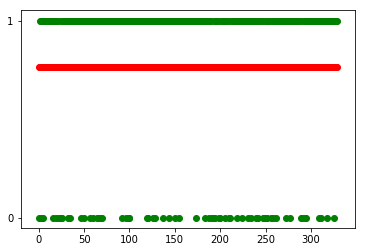

In [48]:
plt.scatter(range(330),predict,c='r')
plt.scatter(range(330),y_test,c='g')
plt.show()